## Parameters

In [1]:
org = 'jupyterhub'
repo = 'jupyterhub'
plot_N = 25  # Number of lines to add

In [2]:
# Parameters
org = "jupyter"
repo = "repo2docker"
plot_N = 20


## Functions

In [3]:
def selectable_line_plot(data, x, y, color, width=1000):

    select = alt.selection(type='single', on='mouseover',
                           fields=[color], nearest=True)

    base = alt.Chart(data=data, width=width).encode(
        x=alt.X(x, scale=alt.Scale(domain=["2016-01-01", "2019-02-01"])),
        y=y,
        color=color,
        tooltip=color,
    )

    points = base.mark_circle(clip=True).encode(
        opacity=alt.value(0)
    ).add_selection(select)


    lines = base.mark_line(clip=True).encode(
        size=alt.condition(~select, alt.value(1), alt.value(4)),
        color=alt.condition(select, color, alt.value('lightgray'))
    )

    return points + lines

# Load data

In [4]:
import pandas as pd
import seaborn as sns
import altair as alt
import numpy as np

In [5]:
# Read in data
daily = pd.read_csv('../data/daily.csv', index_col=0)

# Convert indices to date
daily['date'] = pd.to_datetime(daily['date'])
daily = daily.query('org == @org and repo == @repo').drop(['org', 'repo'], axis=1)
daily = daily.replace(np.nan, 0)

# Features

In [6]:
weekly = daily.groupby('user').resample('W', on='date').sum().reset_index()
weekly = weekly.query('commits != 0 or comments != 0')

In [7]:
# Rolling mean
weekly = weekly.groupby(['user', 'date']).sum().reset_index().groupby('user').\
    rolling(2, on='date')['comments'].\
    mean().dropna().reset_index()

In [8]:
# Top N commentors over time
top_N = weekly.groupby('user').sum()['comments'].sort_values(ascending=False)
top_N = top_N.index[:plot_N]

# Plotting

## Weekly unique contributors

In [9]:
unique = weekly[['date', 'user']].copy()
unique['user'] = unique['user'].map(lambda a: [a])
unique = unique.groupby('date').sum()

In [10]:
all_users = set()
nunique = {}
for idate, ivals in unique.iterrows():
    n_unique_current = len(all_users)
    
    all_users = all_users.union(ivals[0])
    n_unique_new = len(all_users) - n_unique_current
    nunique[idate] = n_unique_new
unique['new_contributors'] = pd.Series(nunique).values

In [11]:
unique['cumulative'] = unique['new_contributors'].cumsum()

In [12]:
line = alt.Chart(data=unique.reset_index(), width=500).mark_line().encode(x='date', y='cumulative')
line

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


## Comment activity over time

In [13]:
# Select the users we'll plot
user_data = weekly.groupby(['user', 'date']).sum().reset_index('user')
total_users = user_data.groupby('user')['comments'].sum()
plt_users = total_users.sort_values(ascending=False)[:plot_N].index
user_data = user_data.query("user in @plt_users")

# Drop empty dates
user_data = user_data[user_data.sum(1) != 0]

In [14]:
selectable_line_plot(user_data.reset_index(), 'date', 'comments', 'user')

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [15]:
# Comment totals over time
all_user_data = user_data.reset_index().groupby('date').sum()['comments'].reset_index()
alt.Chart(data=all_user_data, width=1000).mark_line(clip=True).encode(
    x=alt.X('date', scale=alt.Scale(domain=["2016-01-01", "2019-02-01"])),
    y='comments',
)

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


## Distribution of comments over top N contributors

In [16]:
# For each week, calculate the top 20 contributions, turn them into percentages, order them, store the result

In [17]:
monthly = weekly.groupby('user').resample('M', on='date').sum().reset_index()

In [18]:
n_comments_plot = 20

In [19]:
monthly_dist = {}
for iweek, ivals in monthly.groupby('date'):
    comments_dist = ivals.groupby('user').sum()['comments']
    comments_dist = comments_dist / comments_dist.sum()
    comments_dist = comments_dist.sort_values(ascending=False)
    comments_placeholder = [0] * n_comments_plot

    for ii, (iname, ipart) in enumerate(comments_dist.items()):
        if ii + 1 > n_comments_plot:
            continue
        comments_placeholder[ii] = ipart
    monthly_dist[iweek] = comments_placeholder

In [20]:
monthly_dist = pd.DataFrame(monthly_dist)
# monthly_dist.index.name = 'position'
# monthly_dist.columns.name = 'date'
# monthly_dist = monthly_dist.stack().reset_index().rename(columns={0: 'dist'})

In [21]:
monthly_dist.columns = monthly_dist.columns.date

In [22]:
from matplotlib import pyplot as plt

/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


[Text(114.0, 0.5, 'Rank'),
 Text(0.5, 1.0, 'Log % Comments over time\ntop 20 commentors')]

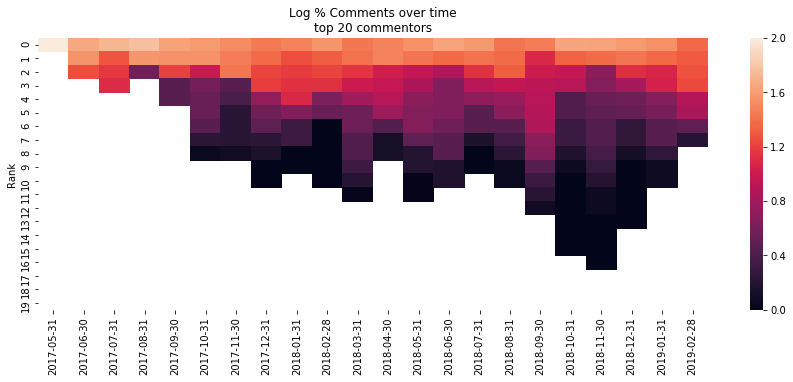

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(np.log10(100 * monthly_dist), vmin=0, vmax=2)
ax.set(ylabel="Rank", title="Log % Comments over time\ntop {} commentors".format(n_comments_plot))

## Correlations between members

In [24]:
correlations = weekly.query("user in @plt_users").set_index(['date', 'user'])['comments'].unstack('user').corr()
correlations = correlations.replace(np.nan, 0)

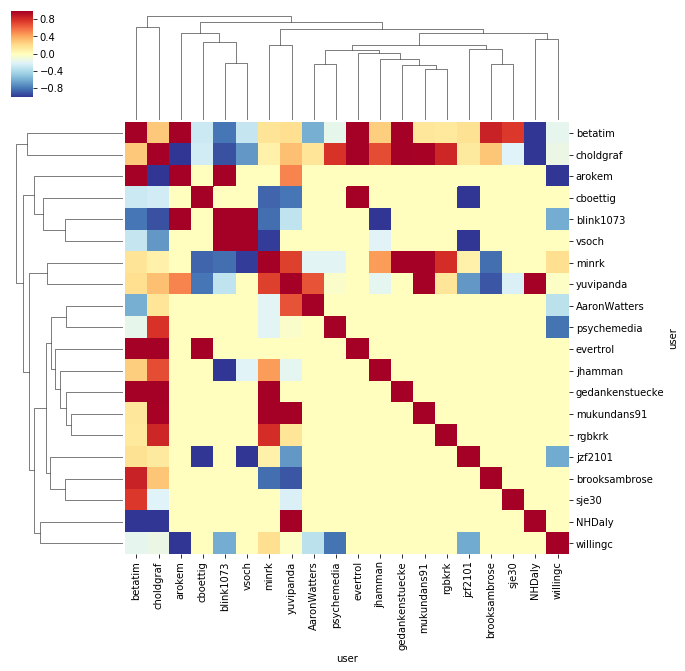

In [25]:
sns.clustermap(correlations, vmin=-1, vmax=1, cmap='RdYlBu_r')